# Problem - Whale Identification

The purpose of this model is create a whale identification model based on previous data. First step is prepare the data to be digested by the model.

# Load Data

The data is loaded using Kaggle's API.

In [5]:
!kaggle competitions list

401 - Unauthorized


In [6]:
!kaggle competitions files -c humpback-whale-identification

401 - Unauthorized


In [7]:
!kaggle competitions download -c humpback-whale-identification

401 - Unauthorized


# Organizing the Dataset

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision import models
from PIL import Image
from itertools import combinations, chain
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
class WhaleDataset(Dataset):
    """
    Creates the dataset to train the model.
    """
    def __init__(self, csv_file, root_dir, transforms, min_imgs=5, split=.8, neg_ratio=2):
        """     
        Args: 
            root_dir (string): Path to diretory with images.
            csv_file (string): Path to csv with all the images.
            kind (string): train ratio of data.
            transforms (list): Optional list with train/test transforms to be applied to images.
            pos_ratio (float): Ratio of positive/negative matches present in dataset.
            min_imgs (int): Minimal number of images in the dataset to create combinations.
        Retun:
            Dataset object
        """
        # Prepare DataFrame with the pair of images
        combined_pos_list = []
        whales_frame = pd.read_csv(csv_file)
        # Series with list of images for each ID
        pos_img_series = whales_frame.groupby('Id').agg(lambda x: ",".join(x)).drop("new_whale")["Image"]
        # Series of non-matching images
        false_img_series = whales_frame.groupby('Id').agg(lambda x: x.iloc[0])["Image"]
        # Calculates combinations of positive matches
        for idx, v in pos_img_series.iteritems():
            imgs = v.split(",")
            if len(imgs) > min_imgs:
                combined = combinations(imgs, 2)
                combined_pos_list.append(combined)
        
        # Positive matches
        positive = pd.DataFrame(list(chain(*combined_pos_list)), columns=["image_1", "image_2"])
        positive["label"] = 1
        
        # Calculates negative matches for all idx
        combined_neg = combinations(false_img_series, 2)
        combined_neg = list(combined_neg)[:neg_ratio * len(positive)]
        negative = pd.DataFrame(combined_neg, columns=["image_1", "image_2"])
        negative["label"] = 0
        
        
        # Join both frames
        self.data_raw = pd.concat([positive, negative], axis=0, join='outer', ignore_index=True)
        
        # Shuffle
        self.data_shuffled = self.data_raw.sample(frac=1).reset_index(drop=True).copy()
        # Split in train/test
        split_pos = int(len(self.data_raw) * split)
        self.train_data = self.data_shuffled.iloc[:split_pos, :]
        self.test_data = self.data_shuffled.iloc[split_pos:, :]
            
        self.root_dir = root_dir
        
        # Transforms
        self.transform = None
        self.transforms = transforms
        
        self.set_mode("train")
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Load images
        img_1_path = os.path.join(self.root_dir,
                                  self.data.iloc[idx, 0])
        img_2_path = os.path.join(self.root_dir,
                                  self.data.iloc[idx, 1])
        img_1 = Image.open(img_1_path).convert('RGB')
        img_2 = Image.open(img_2_path).convert('RGB')
        
        
        # Data augmentation
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
        
        img_1_sample = {'name': img_1_path, 'data': img_1}
        img_2_sample = {'name': img_2_path, 'data': img_2}
        
        # Label for image pair
        label = torch.tensor(int(self.data.iloc[idx, 2]))
        
        # Output
        sample = (img_1_sample, img_2_sample, label)
        
        return sample
    
    def set_mode(self, mode):
        if mode == "train":
            self.data = self.train_data
            self.transform = self.transforms[0]
        elif mode == "test":
            self.data = self.test_data
            self.transform = self.transforms[1]
        else:
            raise "Mode shoud be 'train' or 'test'."

In [3]:
csv_file = 'humpback-whale-identification\\train.csv'
root_dir = 'humpback-whale-identification\\train'
# data augmentation
train_transform = T.Compose([T.Resize((255, 255)),
                             T.RandomRotation(5),
                             T.RandomGrayscale(),
                             T.CenterCrop(224),
                             T.ToTensor(),
                             T.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                            ])

test_transform = T.Compose([T.Resize((255, 255)),
                            T.CenterCrop(224),
                            T.ToTensor(),
                            T.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
                           ])

whale_dataset = WhaleDataset(csv_file, root_dir, transforms=[train_transform, test_transform], neg_ratio=1, split=.85, min_imgs=10)

In [4]:
data_loader = DataLoader(whale_dataset,
                         batch_size=1,
                         shuffle=True)

In [5]:
whale_dataset.set_mode("train")
len(whale_dataset)

90633

In [6]:
whale_dataset.set_mode("test")
len(whale_dataset)

15995

torch.Size([1, 3, 224, 224])
['humpback-whale-identification\\train\\2f31725c6.jpg']
0


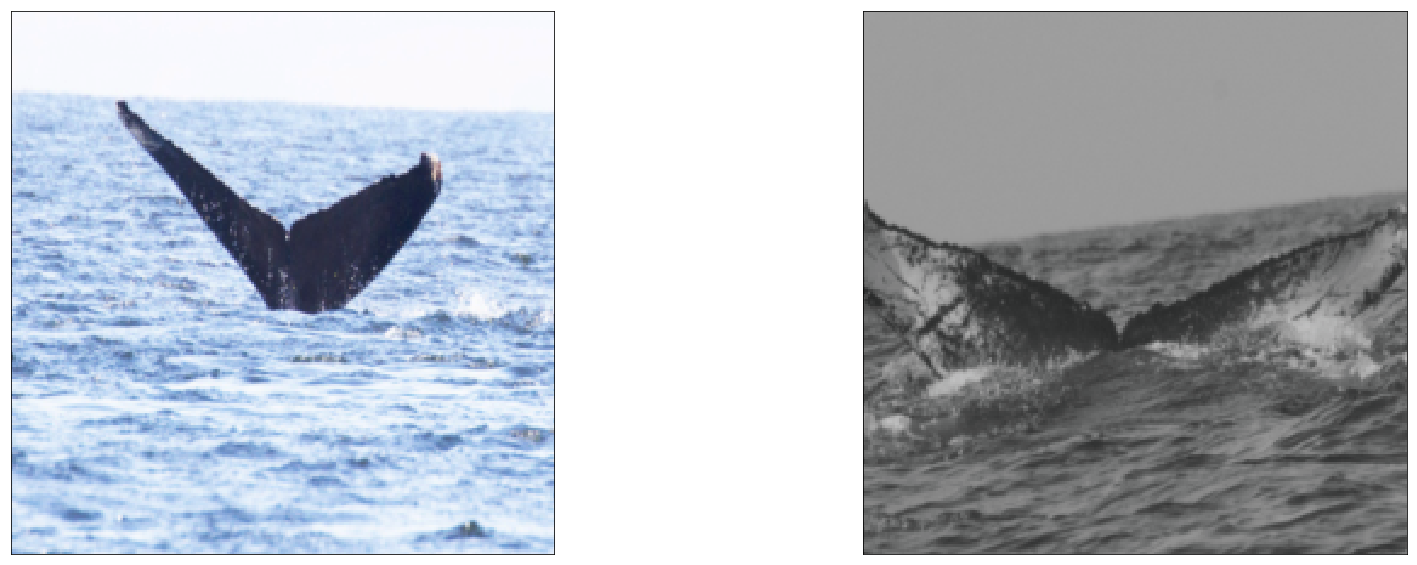

In [7]:
# Check data
img1, img2, label = iter(data_loader).next()

# 5 cropped images
print(img1["data"].size())
print(img1["name"])
# 1 item of the batch
imgs_1 = img1["data"][0].numpy()
imgs_2 = img2["data"][0].numpy()
f = plt.figure(figsize=(28, 10))
# For each img
ax1 = f.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax2 = f.add_subplot(1, 2, 2, xticks=[], yticks=[])
mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
ax1.imshow(np.clip(np.transpose(imgs_1 * std + mean, (1, 2, 0)), 0, 1))
ax2.imshow(np.clip(np.transpose(imgs_2 * std + mean, (1, 2, 0)), 0, 1))
print(label[0].numpy())


In [8]:
# Dataloader
data_loader = DataLoader(whale_dataset,
                         batch_size=24,
                         shuffle=True)

In [9]:
whale_dataset.set_mode("train")
print(len(data_loader))

3777


In [10]:
whale_dataset.set_mode("test")
print(len(data_loader))

667


#### Reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

# Building and Training a Model

Model from the ground

The model will consist of a feture extrator for the whale pictures.

In [11]:
import torch
from torch import nn
from torch import optim
import torch.functional as F
from tqdm import tqdm

In [12]:
# Model
class WhaleSimilarity(nn.Module):
    """
    Network defining class.
    
    Args:
        features_net: Network to get the features from the images. 
                      Should contain the attribute `num_features`.
    """
    def __init__(self, features_net=None):
        super(WhaleSimilarity, self).__init__()
        if features_net is None:
            # Sequence of Convolution + Maxpool Layers
            self.features = nn.Sequential(nn.Conv2d(3, 8, 3, padding=1),  # sees 224x224x3 tensor
                                          nn.ReLU(),
                                          nn.MaxPool2d(2,2),
                                          nn.Conv2d(8, 16, 3, padding=1),  # sees 112x112x8 tensor
                                          nn.ReLU(),
                                          nn.MaxPool2d(2,2),
                                          nn.Conv2d(16, 32, 3, padding=1),  # sees 56x56x16 tensor
                                          nn.ReLU(),
                                          nn.MaxPool2d(2,2),
                                          nn.Conv2d(32, 48, 3, padding=1),  # sees 28x28x32 tensor
                                          nn.ReLU(),
                                          nn.MaxPool2d(2,2),
                                          nn.Conv2d(48, 80, 3, padding=1),  # sees 14x14x48 tensor
                                          nn.ReLU(),
                                          nn.MaxPool2d(2,2)  # outputs 7x7x80 tensor
                                         )
            self.num_features = 80 * 7 * 7
        else:
            self.features = features_net.features
            self.num_features = features_net.num_feats
        
        # Linear layer with sigmoid
        self.fc = nn.Linear(self.num_features, 1)
       
    def get_features(self, x):
        """Pass only in feature extrator"""
        # Sequence of Conv2D + Maxpool
        x = self.features(x)
        # Flatten result
        x = x.view(-1, self.num_features)
        
        return x
    
    def forward(self, x1, x2):
        """
        Forward pass in the network, assuming the feature vectors, x1 and x2.
        
        Args: 
            x1: first imagetensor
            x2: second image tensor    
        """
        
        # Subtrack results
        x = torch.abs(x1 - x2)
        # Linear neuron
        x = torch.sigmoid(self.fc(x))        
        return x
    
    def clean_cache(self):
        """
        Cleans cache. Shoudl be called after weights update.
        """
        self.cache = {}
        

In [13]:
# check if CUDA is available
train_device = 'cuda' if torch.cuda.is_available() else 'cpu'

if train_device == 'cpu':
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [15]:
# Defines Model
model = WhaleSimilarity()
model.to(train_device)

WhaleSimilarity(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(48, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3920, out_features=1, bias=True)
)

In [16]:
# Specify loss function (Binary Cross-entropy)
criterion = nn.BCELoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Specify lr scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Losses array
losses = {"train":[], "valid":[]}

In [14]:
# Auxiliary functions
def save_checkpoint(model, optimizer, scheduler, epoch, losses, file_name):
    """
    Saves the current model checkpoint
    
    Args:
        model: Model used.
        optimizer: Optimizer used.
        Scheduler: Scheduler used.
        epoch: Epouch number.
        losses: Dict with the losses.
        file_name: name of the saved file.
        
    """
    # Saves the model
    checkpoint = {"model_state_dict": model.state_dict(),
                  "optim_state_dict": optimizer.state_dict(),
                  "scheduler_state_dict": scheduler.state_dict(),
                  "epoch": epoch,
                  "train_loss": losses["train"],
                  "valid_loss": losses["valid"]}
    torch.save(checkpoint, file_name)
    
def load_checkpoint(model, optimizer, scheduler, losses, file_name, location='cuda'):
    """
    Load all info from last model.
    
    Args:
        model: Initialized Model.
        optimizer: Initialized Optimizer.
        Scheduler: Initialized Scheduler.
        losses: Initialized Dict with the losses.
        file_name: name of the saved file.
        location: Where to load the model.
    """
    # Loads the model
    checkpoint = torch.load(file_name, map_location=location)
    
    # Load in given objects
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optim_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    losses["train"] = checkpoint["train_loss"]
    losses["valid"] = checkpoint["valid_loss"]

In [15]:
# save_checkpoint(model, optimizer, scheduler, 1, losses, 'whale_model_last.pth')
# load_checkpoint(model, optimizer, scheduler, losses, 'whale_model_last.pth')

In [16]:
def train(model, optimizer, criterion, whale_dataset, data_loader, n_epochs=3, init_val_loss=np.Inf, print_every=100, train_device='cuda'):
    """
    Function to train the model
    
    Args:
        model: Model used.
        optimizer: Optimizer used.
        criterion: Criterion used
        whale_dataset: Data used.
        data_loader: Dataloader used
        n_epochs: Max number of epochs.
        init_val_loss: Initial validation loss.
        print_very: print this number of batches.
        train_device: device used for training.
    """
    # model = model.to(train_device).double()
    for epoch in range(1, n_epochs + 1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        whale_dataset.set_mode("train")
        total_train = len(data_loader.dataset)
        pbar = tqdm(enumerate(data_loader, 1), total=total_train)
        for c, (img1, img2, target) in pbar:
            # move tensors to GPU if CUDA is available
            img1, img2, target = img1["data"].to(train_device), img2["data"].to(train_device), target.to(train_device).float()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            bs = img1.size(0)
            img1_feats = model.get_features(img1)
            img2_feats = model.get_features(img2)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(img1_feats, img2_feats)
            # calculate the batch loss
            #import ipdb; ipdb.set_trace() # debugging starts here
            loss = criterion(output, target.view(bs, -1))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item() * bs
            # show partial results
            if c % print_every == 0:
                # print training/validation statistics 
                pbar.set_description('Batch: {:5d}/{:5d} Training Loss: {:2.6f}'.format(
                c,
                len(data_loader),
                train_loss / (bs * c)
                ))
        
        # Validate model
        valid_loss,_ , _ =  validate_model(model, criterion, whale_dataset, data_loader, train_device)
        
        # calculate average losses
        train_loss = train_loss / total_train
        
        # Save the model if validation loss has decreased
        save_model = False
        if valid_loss < valid_loss_min:
            # update the min_loss
            valid_loss_min = valid_loss
            # Saves the model
            save_checkpoint(model, optimizer, scheduler, epoch, losses, "Model_" + str(epoch))
            save_model = True

        # print training/validation statistics 
        print('Epoch: {:3d}/{:3d} Training Loss: {:2.6f} Validation Loss: {:2.6f} Saving Model: {}'.format(
            epoch,
            n_epochs,
            train_loss,
            valid_loss,
            save_model
            ))

        # Scheduler step
        scheduler.step(valid_loss)
    

def validate_model(model, criterion, whale_dataset, data_loader, train_device='cuda'):
    """
    Validathede given model on dataloader
    
    Args:
        model: Model used.
        criterion: Criterion used
        whale_dataset: Data used.
        data_loader: Dataloader used
        train_device: device used for validation.
    """
    ######################    
    # validate the model #
    ######################
    valid_loss = 0.0
    model = model.to(train_device)
    preds = np.array([])
    targets = np.array([])
    whale_dataset.set_mode("test")
    total_valid = len(data_loader.dataset)
    model.eval()
    cache = dict()
    with torch.no_grad():
        for img1, img2, target in tqdm(data_loader, total=total_valid):
            # Saves cache
            name1 = img1["name"][0]
            name2 = img1["name"][0]
            
            # move tensors to GPU if CUDA is available
            img1, img2, target = img1["data"].to(train_device), img2["data"].to(train_device), target.to(train_device).float()
            bs = img1.size(0)
            
            # Check cache
            if name1 in cache.keys():
                img1_feats = cache[name1]
            else:
                img1_feats = model.get_features(img1)
                cache[name1] = img1_feats
            if name2 in cache.keys():
                img2_feats = cache[name2]
            else:
                img2_feats = model.get_features(img2)
                cache[name2] = img2_feats
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(img1_feats, img2_feats)

            # calculate the batch loss
            loss = criterion(output, target)
            
            # Prediction
            pred = (output >= .5).int()
            preds = np.concatenate((preds, pred.view(-1).cpu().numpy()))
            targets = np.concatenate((targets, target.view(-1).cpu().numpy()))
            # update average validation loss 
            valid_loss += loss.item() * bs
    # Valid loss
    valid_loss = valid_loss / total_valid

    return valid_loss, targets, preds

In [17]:
# TODO - fix
def predict(model, img1_path, img2_path, transform, train_deive='cuda'):
    """
    Returns the model prediction on given image pair
    
    Args:
        model: Model used.
        img1_path: Path to first image.
        img2_path: Path to second image.
        transform: Transforms applied to images.
        train_device: device used for propagation.
    """
    # Load images
    img1 = Image.open(img1_path).convert("RGB")
    img2 = Image.open(img2_path).convert("RGB")
    
    # Applies transforms
    img1 = transform(img1)
    img1 = transform(img1)
    
    model.eval()
    with torch.no_grad():
        # move tensors to GPU if CUDA is available
        img1, img2 = img1.to(train_device), img2.to(train_device)
        model = model.to(train_device)
        
        # Compesate 5 Crop
        ncrops, c, h, w = img1.size()
        img1 = img1.view(-1, c, h, w)
        img2 = img2.view(-1, c, h, w)

        output = model(img1, img2)
        # Mean result of 5 crops
        output = output.view(ncrops, -1).mean(1)
        
        return torch.int8(output >= .5).numpy()

# Model Metrics
Currently, using AUC ROC Curve as the main metric.

In [18]:
# TODO - fix

from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc(score, fpr, tpr):
    """
    Plot ROC curve of the model in th evlidation data
    
    score: ROC score (AUC)
    fpr: False positive rate.
    tpr: true positive rate.
    """
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (Score = %0.2f)' % score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [15]:
# score, fpr, tpr = validate_model(model, criterion, whale_dataset, data_loader, train_device='cuda')

In [16]:
# plot_roc(score, fpr, tpr)

# Transfer Learning

Using transfer learning as features extractors.

In [19]:
# Load Pretrained Models
resnet50 = models.resnet50(pretrained=True)
# resnet152 = models.resnet152(pretrained=True)

# alexnet = models.alexnet(pretrained=True)

# squeezenet = models.squeezenet1_0(pretrained=True)

vgg16 = models.vgg19(pretrained=True)
# vgg19 = models.vgg19(pretrained=True)

densenet121 = models.densenet121(pretrained=True)
# densenet161 = models.densenet161(pretrained=True)

# inception3 = models.inception_v3(pretrained=True)

c:\program files\python36\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [61]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [20]:
# Add attributes to models
resnet50.num_feats = 2048
vgg16.num_feats= 25088
densenet121.num_feats = 50176

# TODO Change 1024 to 1024 * 7 * 7
transfer_model = densenet121
transfer_model = transfer_model.to(train_device)

In [21]:
model = WhaleSimilarity(transfer_model)
model = model.cuda()

In [22]:
# Specify loss function (Binary Cross-entropy)
criterion = nn.BCELoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify lr scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Losses array
losses = {"train":[], "valid":[]}

In [23]:
train(model, optimizer, criterion, whale_dataset, data_loader, n_epochs=1)

  0%|                                                                                        | 0/15995 [00:00<?, ?it/s]c:\program files\python36\lib\site-packages\torch\nn\functional.py:1594: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
  4%|███▏                                                                        | 666/15995 [08:04<3:18:48,  1.29it/s]c:\program files\python36\lib\site-packages\torch\nn\functional.py:1594: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
  4%|███▏                                                                        | 667/15995 [08:05<2:44:13,  1.56it/s]


UnboundLocalError: local variable 'valid_loss_min' referenced before assignment